In [ ]:
# This code is to train a model to detect the abnormality 
# in the humerus xray.

In [1]:
import os
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation,Dropout
from keras import regularizers
from keras.optimizers import Adam, Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = 'XR_HUMERUS/train'
valid_path = 'XR_HUMERUS/valid'
test_path = 'XR_HUMERUS/test'

In [3]:
# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1145 images belonging to 2 classes.
Found 127 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


In [4]:
# Confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
#Set the model to be = MobileNet with trained weights transfered.
mobile = keras.applications.mobilenet.MobileNet()

In [41]:
# Modify the structure by removing the last 5 layers 
# and then adding and two dense layers with relu activation
# dropout and one dense layer without dropout 
# and output layer with 7 neurons and softmax activation
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)
x = model.layers[-2].output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

In [43]:
# verify changes
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [144]:
# This cell and the one below is to control which 
# layers to be freezed and which to be trained
for layer in model.layers[:]:
    layer.trainable = False

In [145]:
for layer in model.layers[:-50]:
    layer.trainable = True

In [146]:
# compile the model
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [147]:
# start training
model.fit_generator(train_batches, steps_per_epoch=163, 
                    validation_data=valid_batches, validation_steps=127, epochs=10, verbose=2)


Epoch 1/10
 - 15s - loss: 0.6371 - acc: 0.6724 - val_loss: 0.7454 - val_acc: 0.5790
Epoch 2/10
 - 9s - loss: 0.6002 - acc: 0.6902 - val_loss: 0.6562 - val_acc: 0.6565
Epoch 3/10
 - 9s - loss: 0.5721 - acc: 0.7301 - val_loss: 0.7175 - val_acc: 0.5897
Epoch 4/10
 - 9s - loss: 0.5685 - acc: 0.7417 - val_loss: 1.0053 - val_acc: 0.5645
Epoch 5/10
 - 9s - loss: 0.5433 - acc: 0.7650 - val_loss: 0.7555 - val_acc: 0.6339
Epoch 6/10
 - 9s - loss: 0.5532 - acc: 0.7577 - val_loss: 0.7730 - val_acc: 0.5927
Epoch 7/10
 - 9s - loss: 0.5168 - acc: 0.7963 - val_loss: 0.7149 - val_acc: 0.6854
Epoch 8/10
 - 9s - loss: 0.5164 - acc: 0.8086 - val_loss: 0.8026 - val_acc: 0.7008
Epoch 9/10
 - 9s - loss: 0.5082 - acc: 0.8068 - val_loss: 0.6404 - val_acc: 0.7653
Epoch 10/10
 - 9s - loss: 0.5199 - acc: 0.8037 - val_loss: 0.5961 - val_acc: 0.7661


In [158]:
# Get the labels
test_labels = test_batches.classes
# Rest the cursor to the start of the test set befor testing
test_batches.reset()

In [159]:
# Test the model on the test set
predictions = model.predict_generator(test_batches, steps=29, verbose=1)


29/29 [==============================] - 3s 94ms/step


In [160]:
# Prepare the confusion matrix
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [161]:
# check the labels with thier indices
test_batches.class_indices

{'negative': 0, 'positive': 1}

Confusion matrix, without normalization
[[124  24]
 [ 54  86]]


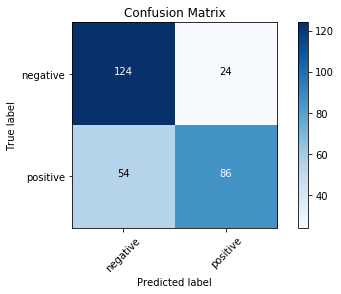

In [162]:
# show the confusion matrix
cm_plot_labels = ['negative','positive']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [163]:
# The overall accuracy of the model
print('Accuracy= ',(cm[0][0]+cm[1][1])*100/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0]),' %')

Accuracy=  72.91666666666667  %


In [164]:
# Prepare the images for (TEST ON STUDY LEVEL)
def prepare_image(file):
    img_path = ''
    img = image.load_img(file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [165]:
# Test the model on the study level:
# 1. all the images in one study are gettting predicted indivisually
# 2. the arithmatic mean of all the images in one study is taken to
#    produce the prediction on the study level

path='MURA-v1.1/valid/XR_HUMERUS/'
img_count=0
img_pos=0
img_neg=0
img_fpos=0
img_fneg=0
true_pos=0
true_neg=0
false_pos=0
false_neg=0
false_pos_lst=[]
false_neg_lst=[]
templst=[]

for patient in os.listdir(path):
    for study in os.listdir(path+patient):
        total_pred=0
        for img in os.listdir(path+patient+'/'+study):
            img_count +=1
            print(path+patient+'/'+study+'/'+img)
            preprocessed_image = prepare_image(path+patient+'/'+study+'/'+img)
            predictions = model.predict(preprocessed_image)
            if predictions[0][1]>0.5 and study.split('_')[1] == 'positive':
                img_pos += 1
            elif predictions[0][1]<=0.5 and study.split('_')[1] == 'negative':
                img_neg += 1
            elif predictions[0][1]>0.5 and study.split('_')[1] != 'positive':
                img_fpos += 1
            else:
                img_fneg += 1
        
            total_pred += predictions[0][1]
        avg_pred = total_pred/len(os.listdir(path+patient+'/'+study))
        if avg_pred <= 0.5:
            abnorm_pred='negative'
        else:
            abnorm_pred='positive'
            
        if abnorm_pred == study.split('_')[1] == 'positive':
            true_pos +=1
        elif abnorm_pred == study.split('_')[1] == 'negative':
            true_neg +=1
        elif abnorm_pred != study.split('_')[1] == 'negative':
            false_pos +=1
            false_pos_lst.append(patient+'/'+study)
        else:
            false_neg +=1
            false_neg_lst.append(patient+'/'+study)


  
  

MURA-v1.1/valid/XR_HUMERUS/patient11577/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11577/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11691/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11691/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11662/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11662/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11702/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11686/study1_negative/image4.png
MURA-v1.1/valid/XR_HUMERUS/patient11686/study1_negative/image3.png
MURA-v1.1/valid/XR_HUMERUS/patient11686/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11686/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11694/study1_negative/image3.png
MURA-v1.1/valid/XR_HUMERUS/patient11694/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11694/study1_negative/image1

MURA-v1.1/valid/XR_HUMERUS/patient11614/study1_positive/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11667/study1_negative/image3.png
MURA-v1.1/valid/XR_HUMERUS/patient11667/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11667/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11674/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11674/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11666/study1_negative/image3.png
MURA-v1.1/valid/XR_HUMERUS/patient11666/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11666/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11616/study1_positive/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11616/study1_positive/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11251/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11251/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11653/study1_positive/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11653/study1_positive/image1

MURA-v1.1/valid/XR_HUMERUS/patient11331/study2_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11688/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11688/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11313/study1_positive/image3.png
MURA-v1.1/valid/XR_HUMERUS/patient11313/study1_positive/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11313/study1_positive/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11613/study1_positive/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11613/study1_positive/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11638/study1_positive/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11638/study1_positive/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11661/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11661/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11275/study1_negative/image2.png
MURA-v1.1/valid/XR_HUMERUS/patient11275/study1_negative/image1.png
MURA-v1.1/valid/XR_HUMERUS/patient11346/study1_positive/image2

In [167]:
## Testing on the original MURA Dataset

print('Total number of images = ',img_count)
print('True Positive = ',img_pos)
print('True Nigative= ',img_neg)
print('False Positive = ',img_fpos)
print('False Nigative= ',img_fneg)
print('Accuracy on IMAGE level =', 100*(img_pos+img_neg)/(img_pos+img_neg+img_fpos+img_fneg))
print('')
print('True Positive = ',true_pos)
print('True Nigative= ',true_neg)
print('False Positive = ',false_pos)
print('False Nigative= ',false_neg)
print('Accuracy on STUDY level =', 100*(true_neg+true_pos)/(true_neg+true_pos+false_neg+false_pos))

Total number of images =  288
True Positive =  86
True Nigative=  124
False Positive =  24
False Nigative=  54
Accuracy on IMAGE level = 72.91666666666667

True Positive =  47
True Nigative=  56
False Positive =  12
False Nigative=  20
Accuracy on STUDY level = 76.29629629629629


In [43]:
#### SAVE MODEL ####

model.save_weights("models/XR_HUMERUS.h5")

#Save the model architecture
with open('models/architecture_XR_HUMERUS.json', 'w') as f:
    f.write(model.to_json())